## Regression Analysis

**Data Manipulation** 

Combining all metro datas into one

In [64]:
## Combining all METRO Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
 
lametro = pd.read_csv("../data/final/metro/mi_final_lametro.csv")
chimetro = pd.read_csv("../data/final/metro/mi_final_chimetro.csv")
dcmetro = pd.read_csv("../data/final/metro/mi_final_dcmetro.csv")
dalmetro = pd.read_csv("../data/final/metro/mi_final_txmetro.csv")

lametro_adj = lametro[["Norm Price","City","dist_hospitals","dist_gym","dist_cemetary","dist_parks","dist_beaches","dist_shopping","dist_grocery","dist_resturant","dist_golf","dist_school"]]
chimetro_adj = chimetro[["Norm Price","City","dist_hospitals","dist_gym","dist_cemetary","dist_parks","dist_beaches","dist_shopping","dist_grocery","dist_resturant","dist_golf","dist_school"]]
dcmetro_adj = dcmetro[["Norm Price","City","dist_hospitals","dist_gym","dist_cemetary","dist_parks","dist_beaches","dist_shopping","dist_grocery","dist_resturant","dist_golf","dist_school"]]
dalmetro_adj = dalmetro[["Norm Price","City","dist_hospitals","dist_gym","dist_cemetary","dist_parks","dist_beaches","dist_shopping","dist_grocery","dist_resturant","dist_golf","dist_school"]]

lametro_adj = lametro_adj.rename(columns={lametro_adj.columns[0]: "Norm" })
chimetro_adj = chimetro_adj.rename(columns={chimetro_adj.columns[0]: "Norm" })
dcmetro_adj = dcmetro_adj.rename(columns={dcmetro_adj.columns[0]: "Norm" })
dalmetro_adj = dalmetro_adj.rename(columns={dalmetro_adj.columns[0]: "Norm" })

metro = pd.concat([lametro_adj,chimetro_adj,dcmetro_adj,dalmetro_adj])
#metro.to_csv("metro.csv")

nummetro = metro.drop(columns = ["City","Norm"])
nummetro = nummetro.reset_index(drop=True)
citymetro = metro[["City","Norm"]]
citymetro = citymetro.reset_index(drop=True)
nummetro = nummetro[(np.abs(stats.zscore(nummetro)) < 3).all(axis=1)]
nummetro = nummetro.join(citymetro)
nummetro = nummetro.drop(nummetro.index[nummetro['Norm'] <= 0])

**Model I**

In [65]:
import pandas as pd
import numpy as np
import statsmodels.api as sm 
from scipy import stats

resulta = sm.OLS(nummetro['Norm'], nummetro.drop(columns=["Norm","City"])).fit() #Initialize the GLS 
print(resulta.summary())

                                 OLS Regression Results                                
Dep. Variable:                   Norm   R-squared (uncentered):                   0.609
Model:                            OLS   Adj. R-squared (uncentered):              0.608
Method:                 Least Squares   F-statistic:                              593.2
Date:                Wed, 07 Dec 2022   Prob (F-statistic):                        0.00
Time:                        18:54:24   Log-Likelihood:                          2057.9
No. Observations:                3825   AIC:                                     -4096.
Df Residuals:                    3815   BIC:                                     -4033.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

Assumption Check:

In [66]:
# Multicollinearity: VIF
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
y, X = dmatrices('Norm ~ dist_hospitals+dist_gym+dist_cemetary+dist_parks+dist_beaches+dist_shopping+dist_grocery+dist_resturant+dist_golf+dist_school', data=nummetro, return_type='dataframe')
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif = vif.set_index("variable")
vif
vif.style.applymap(lambda x: 'background-color : purple' if x>5 else '')

,VIF
variable,
Intercept,8.494220
dist_hospitals,2.217842
dist_gym,2.346233
dist_cemetary,1.502402
dist_parks,1.242660
dist_beaches,1.306936
dist_shopping,2.614708
dist_grocery,2.561494
dist_resturant,3.312526


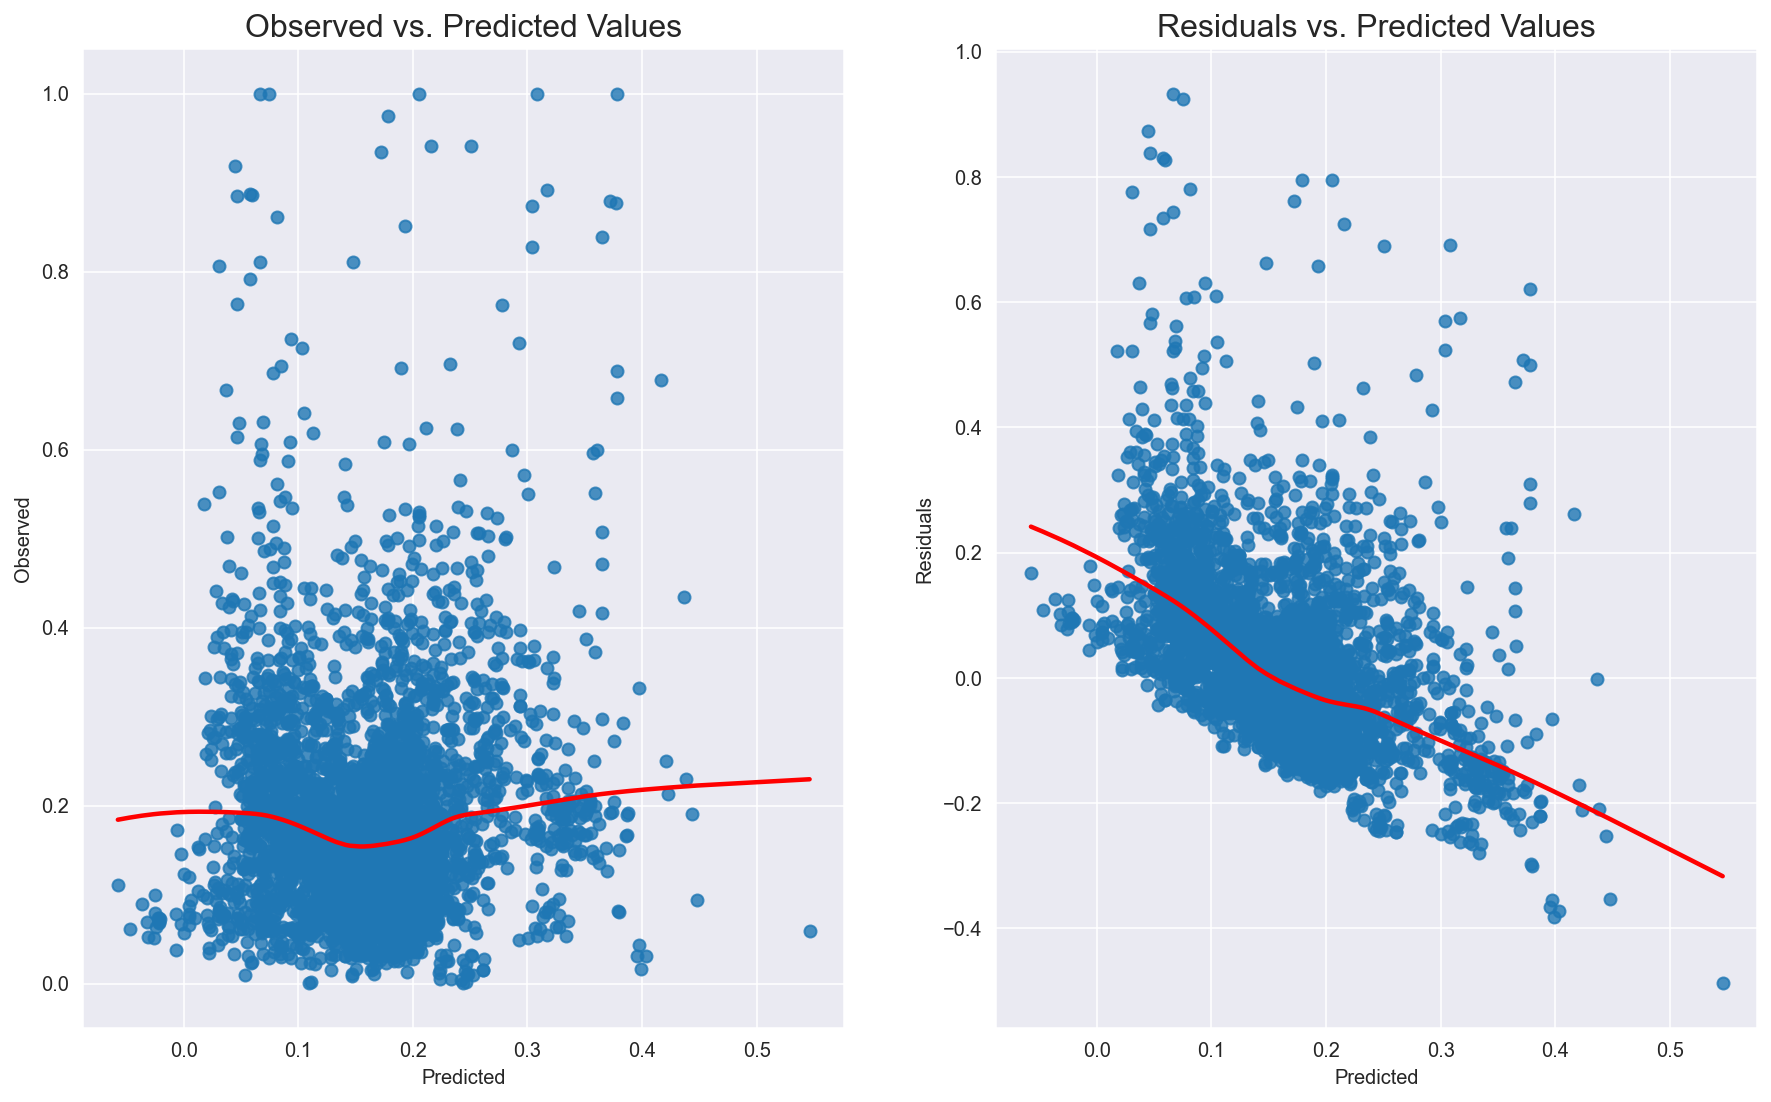

In [67]:
# Residual Plots
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2)
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')
    
linearity_test(resulta, y=nummetro[["Norm"]])    

In [68]:
# Unequal Variances Check: BP
import statsmodels.stats.api as sms
sms.het_breuschpagan(resulta.resid, resulta.model.exog)

(361.9696157591403,
 1.7532063340253935e-72,
 39.87588703827774,
 1.9964650151009448e-75)

Text(0.5, 1.0, 'Model1 Residuals Q-Q Plot')

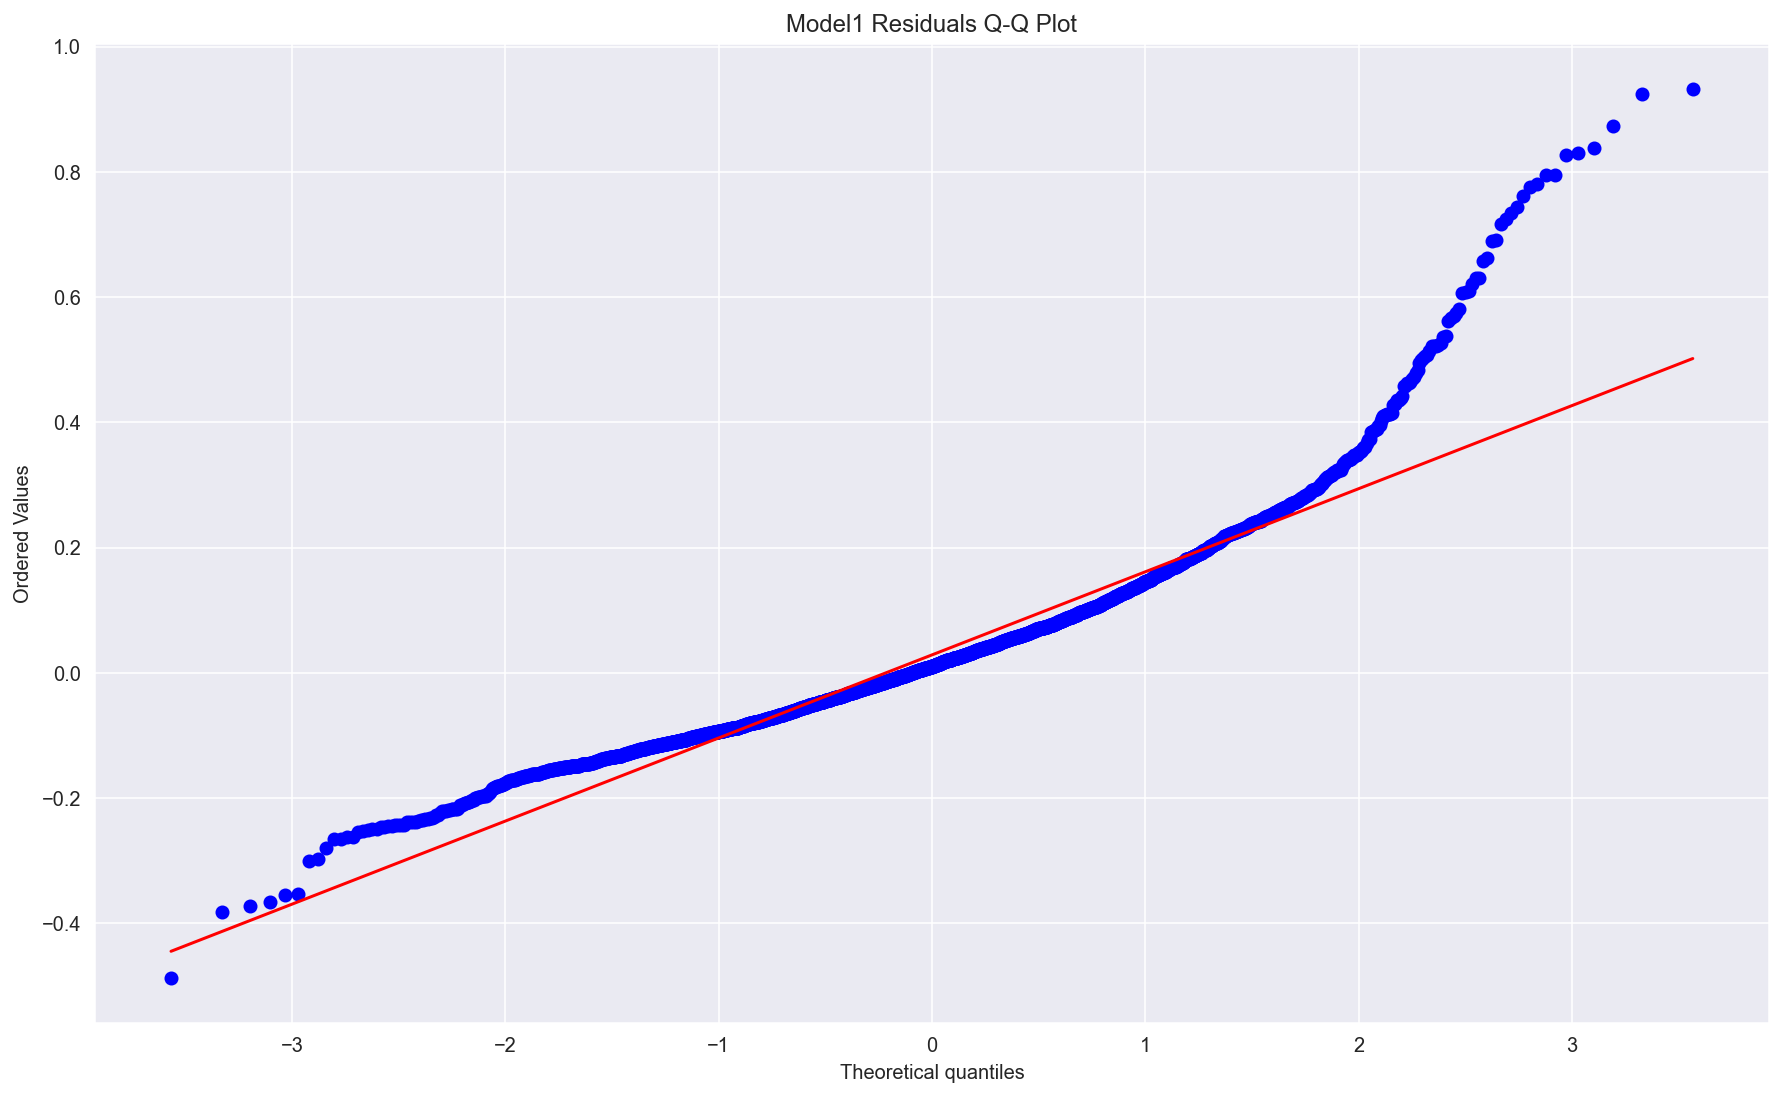

In [69]:
# Normality: QQ Plot
import statsmodels.stats.api
stats.probplot(resulta.resid, dist="norm", plot= plt)
plt.title("Model1 Residuals Q-Q Plot")

**Model II: Reciprocal Transformation**

In [70]:
# DATA MANIPULATION
import numpy as np
nummetro = metro.drop(columns = ["City","Norm"])
nummetro = np.exp(-nummetro)
Q1 = nummetro.quantile(q=.25)
Q3 = nummetro.quantile(q=.75)
IQR = nummetro.apply(stats.iqr)
nummetro = nummetro[~((nummetro < (Q1-1.5*IQR)) | (nummetro > (Q3+1.5*IQR))).any(axis=1)]
nummetro = nummetro.reset_index(drop=True)
citymetro = metro[["City","Norm"]]
citymetro["Norm"] = np.exp(-citymetro["Norm"])
citymetro = citymetro.reset_index(drop=True)

nummetro = nummetro.join(citymetro)
#nummetro.to_csv("test.csv")

C:\Users\timot\AppData\Local\Temp\ipykernel_24720\3781542959.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  citymetro["Norm"] = np.exp(-citymetro["Norm"])


In [71]:
# Regression Analysis
import pandas as pd
import numpy as np
import statsmodels.api as sm 
from scipy import stats

nummetro = nummetro[nummetro.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)] 
resulta = sm.OLS(nummetro['Norm'], nummetro.drop(columns=["Norm","City"])).fit() 
print(resulta.summary())

                                 OLS Regression Results                                
Dep. Variable:                   Norm   R-squared (uncentered):                   0.943
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                              5191.
Date:                Wed, 07 Dec 2022   Prob (F-statistic):                        0.00
Time:                        18:54:28   Log-Likelihood:                          653.55
No. Observations:                3143   AIC:                                     -1287.
Df Residuals:                    3133   BIC:                                     -1227.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [72]:
# Unequal Variances: BP
import statsmodels.stats.api as sms
sms.het_breuschpagan(resulta.resid, resulta.model.exog)
sms.jarque_bera(resulta.resid)

(57.09241300625467,
 4.0044238231757606e-13,
 0.3056542921930303,
 3.24952038984552)

In [47]:
# Multicollinearity: VIF
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
y, X = dmatrices('Norm ~ dist_hospitals+dist_gym+dist_cemetary+dist_parks+dist_beaches+dist_shopping+dist_grocery+dist_resturant+dist_golf+dist_school', data=nummetro, return_type='dataframe')
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif = vif.set_index("variable")
vif
vif.style.applymap(lambda x: 'background-color : purple' if x>5 else '')

,VIF
variable,
Intercept,22.955636
dist_hospitals,1.857717
dist_gym,2.277274
dist_cemetary,1.522103
dist_parks,1.496099
dist_beaches,1.136619
dist_shopping,2.125383
dist_grocery,2.244614
dist_resturant,2.290419


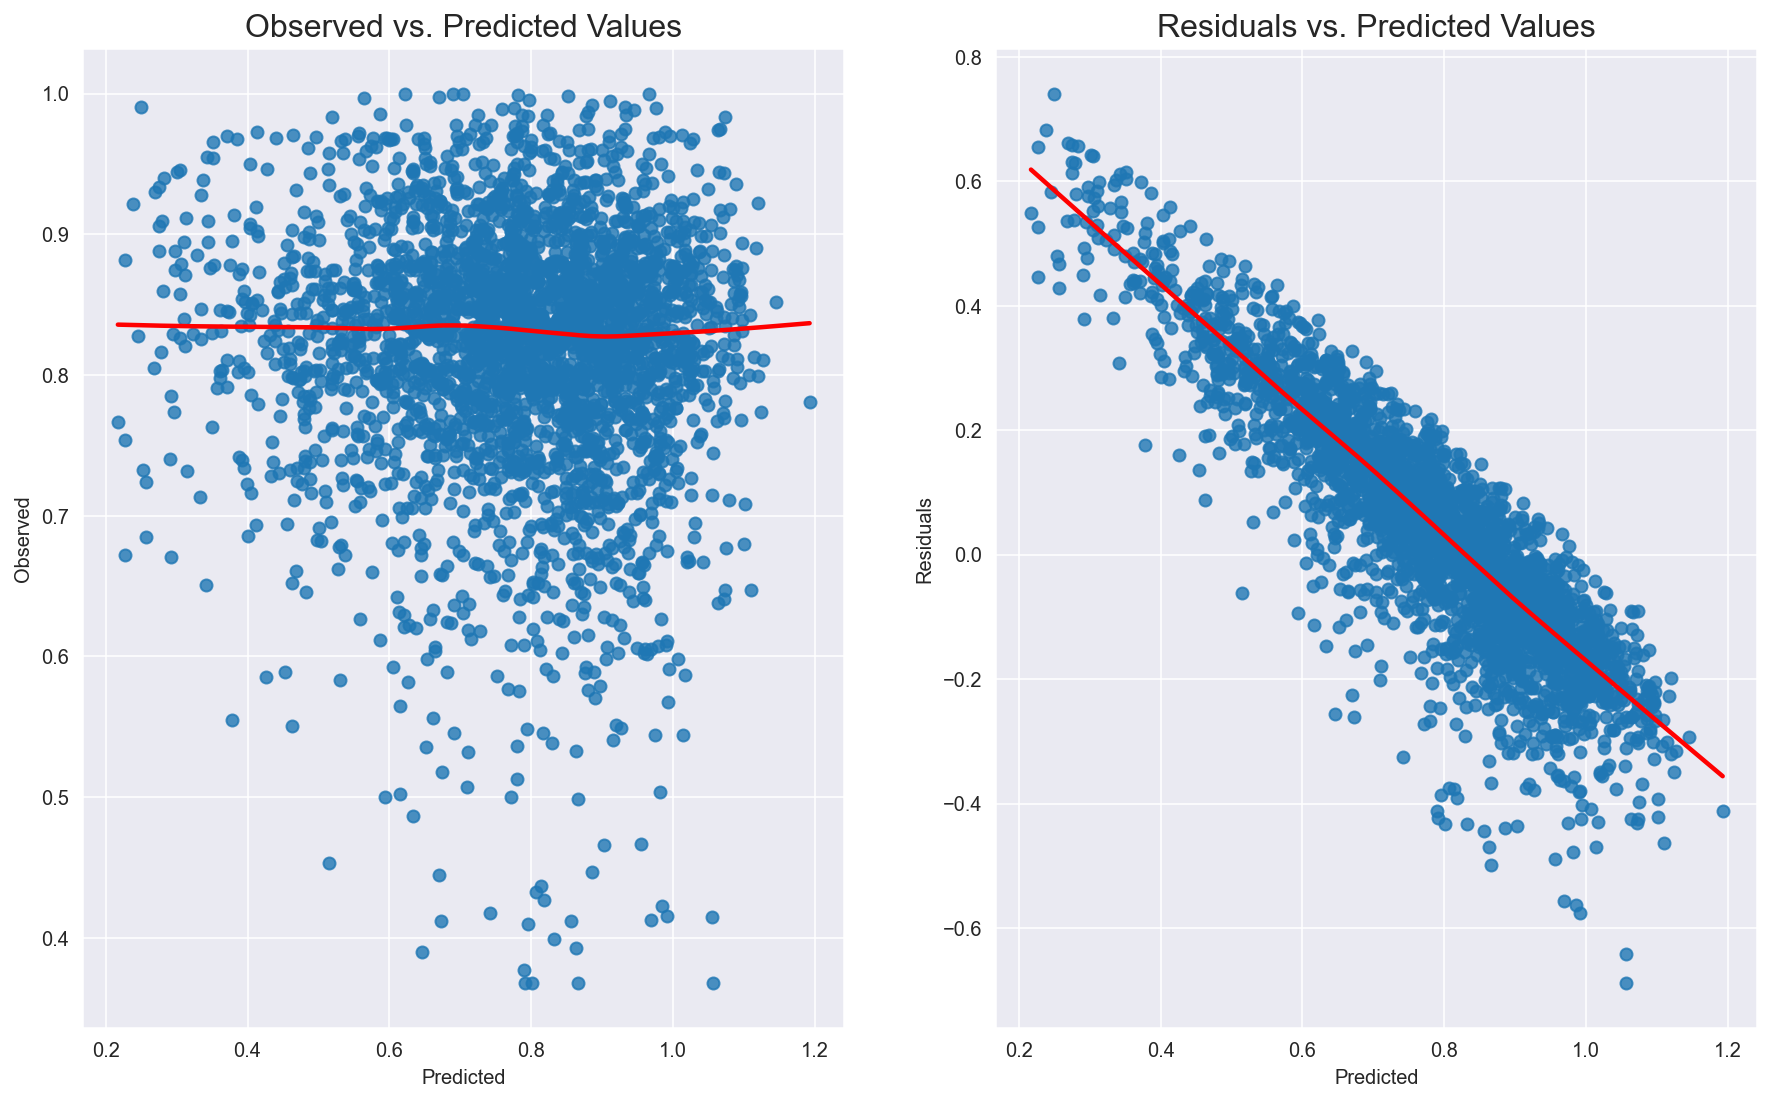

In [48]:
# Residual Plots
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

linearity_test(resulta, y=nummetro[["Norm"]])    

Text(0.5, 1.0, 'Model1 Residuals Q-Q Plot')

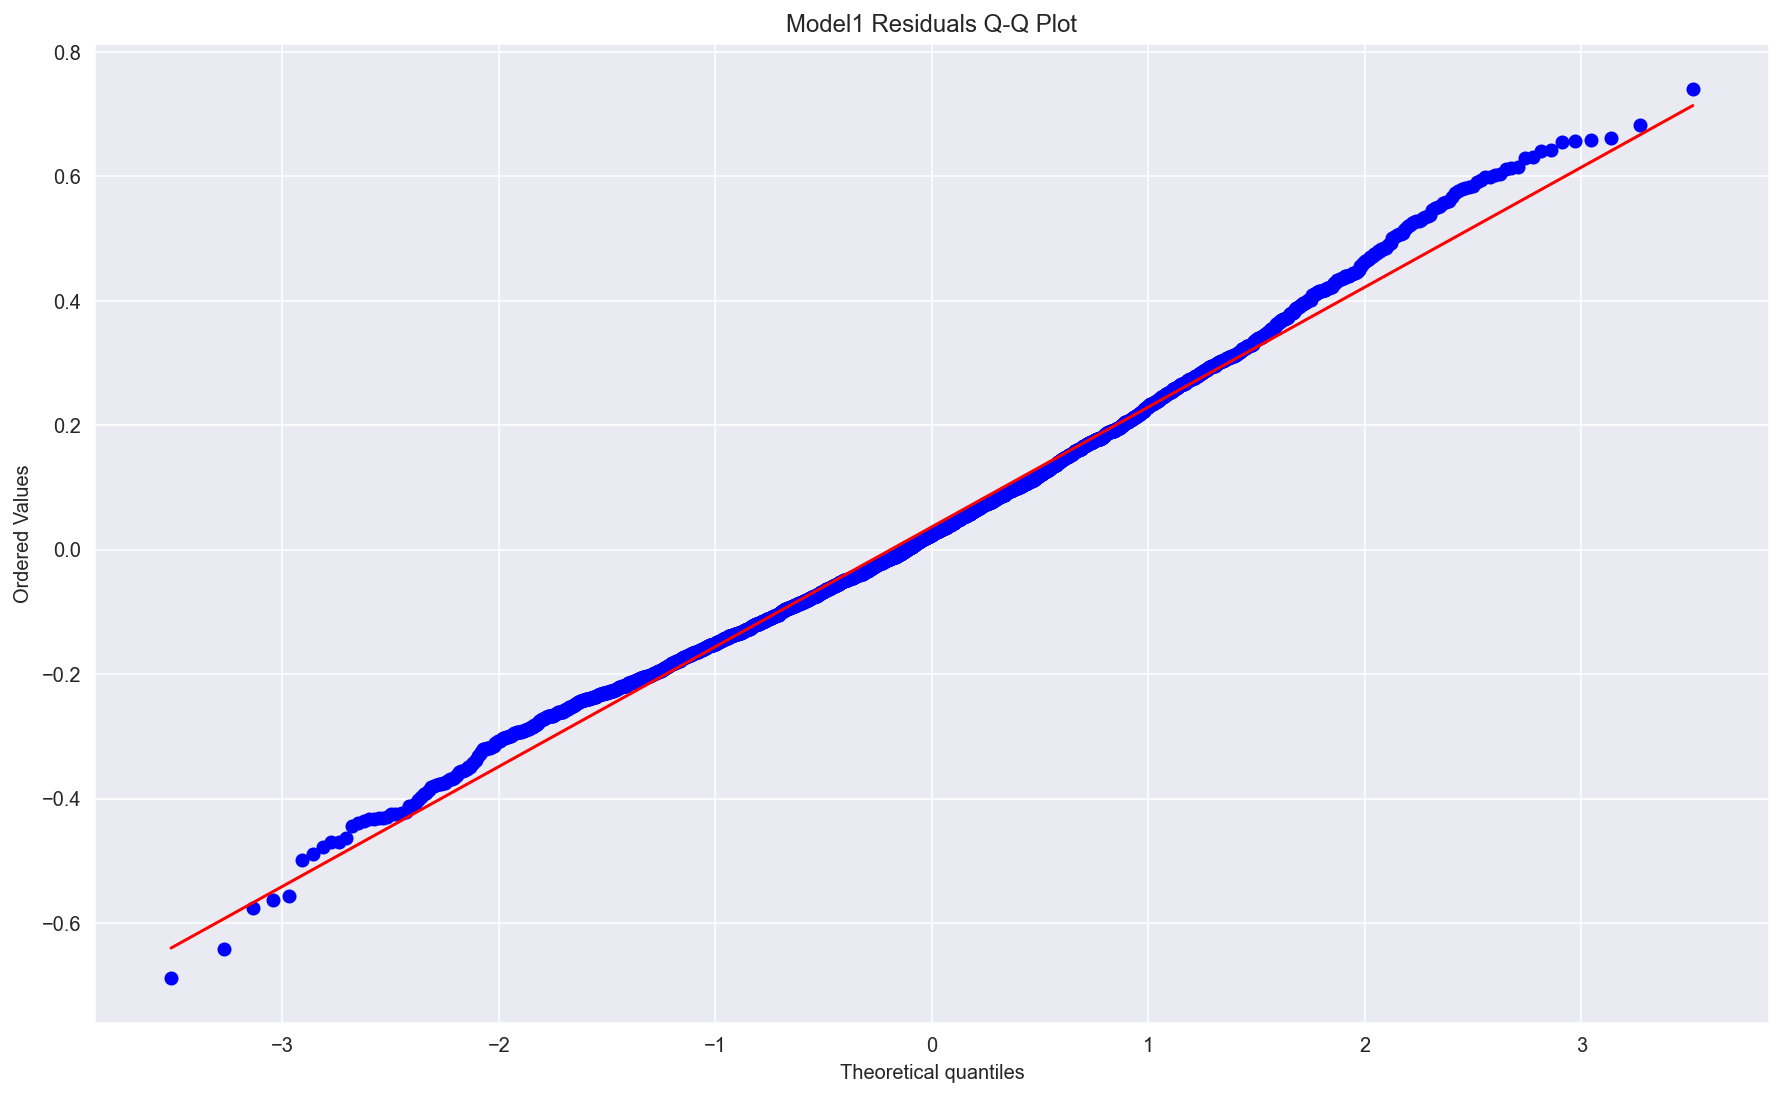

In [49]:
# Normality: QQ Plot
import statsmodels.stats.api
stats.probplot(resulta.resid, dist="norm", plot= plt)
plt.title("Model1 Residuals Q-Q Plot")

**Initial Models: Separate Metro Areas**

In [50]:
# Los Angeles Metro Area
import pandas as pd
import numpy as np
import statsmodels.api as sm 
from scipy import stats

citymetro = lametro_adj[["Norm","City"]]
citymetro = citymetro.reset_index(drop=True)
lametro_adj = lametro_adj.drop(columns = ["City","Norm"])
lametro_adj = lametro_adj.reset_index(drop=True)
lametro_adj = lametro_adj[(np.abs(stats.zscore(lametro_adj)) < 3).all(axis=1)]
lametro_adj = lametro_adj.join(citymetro)
resultla = sm.OLS(lametro_adj['Norm'], lametro_adj.drop(columns=["Norm","City"])).fit() #Initialize the GLS 
print(resultla.summary())

                                 OLS Regression Results                                
Dep. Variable:                   Norm   R-squared (uncentered):                   0.742
Model:                            OLS   Adj. R-squared (uncentered):              0.741
Method:                 Least Squares   F-statistic:                              415.7
Date:                Wed, 07 Dec 2022   Prob (F-statistic):                        0.00
Time:                        18:41:05   Log-Likelihood:                          929.99
No. Observations:                1453   AIC:                                     -1840.
Df Residuals:                    1443   BIC:                                     -1787.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [51]:
# DC Metro Area
import pandas as pd
import numpy as np
import statsmodels.api as sm 
from scipy import stats

citymetro = dcmetro_adj[["Norm","City"]]
citymetro = citymetro.reset_index(drop=True)
dcmetro_adj = dcmetro_adj.drop(columns = ["City","Norm"])
dcmetro_adj = dcmetro_adj.reset_index(drop=True)
dcmetro_adj = dcmetro_adj[(np.abs(stats.zscore(dcmetro_adj)) < 3).all(axis=1)]
dcmetro_adj = dcmetro_adj.join(citymetro)
resultdc = sm.OLS(dcmetro_adj['Norm'], dcmetro_adj.drop(columns=["Norm","City"])).fit() #Initialize the GLS 
print(resultdc.summary())

                                 OLS Regression Results                                
Dep. Variable:                   Norm   R-squared (uncentered):                   0.782
Model:                            OLS   Adj. R-squared (uncentered):              0.780
Method:                 Least Squares   F-statistic:                              359.6
Date:                Wed, 07 Dec 2022   Prob (F-statistic):                   4.04e-291
Time:                        18:41:05   Log-Likelihood:                          795.77
No. Observations:                 910   AIC:                                     -1574.
Df Residuals:                     901   BIC:                                     -1530.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [52]:
# Dallas Metro Area
import pandas as pd
import numpy as np
import statsmodels.api as sm 
from scipy import stats

citymetro = dalmetro_adj[["Norm","City"]]
citymetro = citymetro.reset_index(drop=True)
dalmetro_adj = dalmetro_adj.drop(columns = ["City","Norm"])
dalmetro_adj = dalmetro_adj.reset_index(drop=True)
dalmetro_adj = dalmetro_adj[(np.abs(stats.zscore(dalmetro_adj)) < 3).all(axis=1)]
dalmetro_adj = dalmetro_adj.join(citymetro)
resultdal = sm.OLS(dalmetro_adj['Norm'], dalmetro_adj.drop(columns=["Norm","City"])).fit() #Initialize the GLS 
print(resultdal.summary())

                                 OLS Regression Results                                
Dep. Variable:                   Norm   R-squared (uncentered):                   0.483
Model:                            OLS   Adj. R-squared (uncentered):              0.476
Method:                 Least Squares   F-statistic:                              67.79
Date:                Wed, 07 Dec 2022   Prob (F-statistic):                    4.82e-97
Time:                        18:41:05   Log-Likelihood:                          582.70
No. Observations:                 735   AIC:                                     -1145.
Df Residuals:                     725   BIC:                                     -1099.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [53]:
# Chicago Metro Area
import pandas as pd
import numpy as np
import statsmodels.api as sm 
from scipy import stats

citymetro = chimetro_adj[["Norm","City"]]
citymetro = citymetro.reset_index(drop=True)
chimetro_adj = chimetro_adj.drop(columns = ["City","Norm"])
chimetro_adj = chimetro_adj.reset_index(drop=True)
chimetro_adj = chimetro_adj[(np.abs(stats.zscore(chimetro_adj)) < 3).all(axis=1)]
chimetro_adj = chimetro_adj.join(citymetro)
resultchi = sm.OLS(chimetro_adj['Norm'], chimetro_adj.drop(columns=["Norm","City"])).fit() #Initialize the GLS 
print(resultchi.summary())

                                 OLS Regression Results                                
Dep. Variable:                   Norm   R-squared (uncentered):                   0.502
Model:                            OLS   Adj. R-squared (uncentered):              0.495
Method:                 Least Squares   F-statistic:                              72.79
Date:                Wed, 07 Dec 2022   Prob (F-statistic):                   2.30e-102
Time:                        18:41:05   Log-Likelihood:                          254.87
No. Observations:                 732   AIC:                                     -489.7
Df Residuals:                     722   BIC:                                     -443.8
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [54]:
# VIF Check for All Four Metro Areas
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
yla, Xla = dmatrices('Norm ~ dist_hospitals+dist_gym+dist_cemetary+dist_parks+dist_beaches+dist_shopping+dist_grocery+dist_resturant+dist_golf+dist_school', data=lametro_adj, return_type='dataframe')
ydc, Xdc = dmatrices('Norm ~ dist_hospitals+dist_gym+dist_cemetary+dist_parks+dist_beaches+dist_shopping+dist_grocery+dist_resturant+dist_golf+dist_school', data=dcmetro_adj, return_type='dataframe')
ydal, Xdal = dmatrices('Norm ~ dist_hospitals+dist_gym+dist_cemetary+dist_parks+dist_beaches+dist_shopping+dist_grocery+dist_resturant+dist_golf+dist_school', data=dalmetro_adj, return_type='dataframe')
ychi, Xchi = dmatrices('Norm ~ dist_hospitals+dist_gym+dist_cemetary+dist_parks+dist_beaches+dist_shopping+dist_grocery+dist_resturant+dist_golf+dist_school', data=chimetro_adj, return_type='dataframe')
vif = pd.DataFrame()
vif['VIF LA'] = [variance_inflation_factor(Xla.values, i) for i in range(Xla.shape[1])]
vif['VIF DC'] = [variance_inflation_factor(Xdc.values, i) for i in range(Xdc.shape[1])]
vif['VIF Dal'] = [variance_inflation_factor(Xdal.values, i) for i in range(Xdal.shape[1])]
vif['VIF CHI'] = [variance_inflation_factor(Xchi.values, i) for i in range(Xchi.shape[1])]
vif['variable'] = Xla.columns
vif = vif.set_index("variable")
vif
vif.style.applymap(lambda x: 'background-color : purple' if x>5 else '')

c:\Users\timot\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF LA,VIF DC,VIF Dal,VIF CHI
variable,,,,
Intercept,8.184420,79.543614,9.243854,7.628418
dist_hospitals,1.947248,inf,2.661680,3.336626
dist_gym,3.115004,2.190203,4.771150,2.537263
dist_cemetary,1.207371,1.491105,4.235352,5.763529
dist_parks,1.264889,1.777922,3.578869,1.408013
dist_beaches,1.518500,1.918532,1.399432,5.521943
dist_shopping,2.500467,1.882969,7.095086,5.433059
dist_grocery,2.532443,2.656795,5.272693,5.932845
dist_resturant,2.594981,2.112492,2.763942,4.905423


In [55]:
# UNEQUAL VARIANCE for all Metro Areas
import statsmodels.stats.api as sms
la = sms.het_breuschpagan(resultla.resid, resultla.model.exog)
dc = sms.het_breuschpagan(resultdc.resid, resultdc.model.exog)
dal = sms.het_breuschpagan(resultdal.resid, resultdal.model.exog)
chi = sms.het_breuschpagan(resultchi.resid, resultchi.model.exog)
print(la,dc,dal,chi)

(512.676350936343, 1.1089046478286914e-104, 78.67418575910573, 7.914917271212192e-129) (88.17986757521295, 3.7720189963937195e-15, 10.741747704012502, 5.924354341447277e-16) (33.67559840921923, 0.00010180237789784013, 3.4812433149773465, 0.0001715590758598643) (61.979471841890934, 5.560748631733644e-10, 6.678777259685017, 5.694152026666493e-10)


In [56]:
# NORMALITY for all Metro Areas
import statsmodels.stats.api
la = statsmodels.stats.stattools.jarque_bera(resultla.resid)
dc = statsmodels.stats.stattools.jarque_bera(resultdc.resid)
dal = statsmodels.stats.stattools.jarque_bera(resultdal.resid)
chi = statsmodels.stats.stattools.jarque_bera(resultchi.resid)
print(la,dc,dal,chi)

(299.843272390357, 7.759981439913322e-66, 0.10336745889564564, 5.215837739249637) (4620.715666762293, 0.0, 2.1923776567143536, 13.131088264116018) (12305.491059284503, 0.0, 3.2763953807367128, 21.943940619432304) (1162.7752795823988, 3.2103781575518e-253, 1.6300216978146744, 8.243652993577356)


**Model II for separate metros**

In [57]:
# Los Angeles
import numpy as np
nummetro = lametro_adj.drop(columns = ["City","Norm"])
nummetro = np.exp(-nummetro)
Q1 = nummetro.quantile(q=.25)
Q3 = nummetro.quantile(q=.75)
IQR = nummetro.apply(stats.iqr)
nummetro = nummetro[~((nummetro < (Q1-1.5*IQR)) | (nummetro > (Q3+1.5*IQR))).any(axis=1)]
nummetro = nummetro.reset_index(drop=True)
citymetro = lametro_adj[["City","Norm"]]
citymetro["Norm"] = np.exp(-citymetro["Norm"])
citymetro = citymetro.reset_index(drop=True)
nummetro = nummetro.join(citymetro)
resultla = sm.OLS(nummetro['Norm'], nummetro.drop(columns=["Norm","City"])).fit() #Initialize the GLS 
print(resultla.summary())

C:\Users\timot\AppData\Local\Temp\ipykernel_24720\1806289802.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  citymetro["Norm"] = np.exp(-citymetro["Norm"])


                                 OLS Regression Results                                
Dep. Variable:                   Norm   R-squared (uncentered):                   0.967
Model:                            OLS   Adj. R-squared (uncentered):              0.967
Method:                 Least Squares   F-statistic:                              3482.
Date:                Wed, 07 Dec 2022   Prob (F-statistic):                        0.00
Time:                        18:41:05   Log-Likelihood:                          599.15
No. Observations:                1203   AIC:                                     -1178.
Df Residuals:                    1193   BIC:                                     -1127.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [58]:
# DC
import numpy as np
nummetro = dcmetro_adj.drop(columns = ["City","Norm"])
nummetro = np.exp(-nummetro)
Q1 = nummetro.quantile(q=.25)
Q3 = nummetro.quantile(q=.75)
IQR = nummetro.apply(stats.iqr)
nummetro = nummetro[~((nummetro < (Q1-1.5*IQR)) | (nummetro > (Q3+1.5*IQR))).any(axis=1)]
nummetro = nummetro.reset_index(drop=True)
citymetro = dcmetro_adj[["City","Norm"]]
citymetro["Norm"] = np.exp(-citymetro["Norm"])
citymetro = citymetro.reset_index(drop=True)
nummetro = nummetro.join(citymetro)
resultdc = sm.OLS(nummetro['Norm'], nummetro.drop(columns=["Norm","City","dist_hospitals","dist_school"])).fit() #Initialize the GLS 
print(resultdc.summary())

                                 OLS Regression Results                                
Dep. Variable:                   Norm   R-squared (uncentered):                   0.935
Model:                            OLS   Adj. R-squared (uncentered):              0.935
Method:                 Least Squares   F-statistic:                              1340.
Date:                Wed, 07 Dec 2022   Prob (F-statistic):                        0.00
Time:                        18:41:05   Log-Likelihood:                          91.352
No. Observations:                 749   AIC:                                     -166.7
Df Residuals:                     741   BIC:                                     -129.8
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

C:\Users\timot\AppData\Local\Temp\ipykernel_24720\4248080033.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  citymetro["Norm"] = np.exp(-citymetro["Norm"])


In [59]:
# Chicago
import numpy as np
nummetro = chimetro_adj.drop(columns = ["City","Norm"])
nummetro = np.exp(-nummetro)
Q1 = nummetro.quantile(q=.25)
Q3 = nummetro.quantile(q=.75)
IQR = nummetro.apply(stats.iqr)
nummetro = nummetro[~((nummetro < (Q1-1.5*IQR)) | (nummetro > (Q3+1.5*IQR))).any(axis=1)]
nummetro = nummetro.reset_index(drop=True)
citymetro = chimetro_adj[["City","Norm"]]
citymetro["Norm"] = np.exp(-citymetro["Norm"])
citymetro = citymetro.reset_index(drop=True)
nummetro = nummetro.join(citymetro)
resultchi = sm.OLS(nummetro['Norm'], nummetro.drop(columns=["Norm","City","dist_cemetary","dist_beaches","dist_shopping","dist_grocery"])).fit() #Initialize the GLS 
print(resultchi.summary())

                                 OLS Regression Results                                
Dep. Variable:                   Norm   R-squared (uncentered):                   0.920
Model:                            OLS   Adj. R-squared (uncentered):              0.919
Method:                 Least Squares   F-statistic:                              1039.
Date:                Wed, 07 Dec 2022   Prob (F-statistic):                   8.53e-293
Time:                        18:41:05   Log-Likelihood:                          26.722
No. Observations:                 546   AIC:                                     -41.44
Df Residuals:                     540   BIC:                                     -15.63
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

C:\Users\timot\AppData\Local\Temp\ipykernel_24720\77680650.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  citymetro["Norm"] = np.exp(-citymetro["Norm"])


In [60]:
# Dallas
import numpy as np
nummetro = dalmetro_adj.drop(columns = ["City","Norm"])
#nummetro = np.exp(-nummetro)
Q1 = nummetro.quantile(q=.25)
Q3 = nummetro.quantile(q=.75)
IQR = nummetro.apply(stats.iqr)
nummetro = nummetro[~((nummetro < (Q1-1.5*IQR)) | (nummetro > (Q3+1.5*IQR))).any(axis=1)]
nummetro = nummetro.reset_index(drop=True)
citymetro = dalmetro_adj[["City","Norm"]]
citymetro["Norm"] = np.exp(-citymetro["Norm"])
citymetro = citymetro.reset_index(drop=True)
nummetro = nummetro.join(citymetro)
resultdal = sm.OLS(nummetro['Norm'], nummetro.drop(columns=["Norm","City"])).fit() #Initialize the GLS 
print(resultdal.summary())

                                 OLS Regression Results                                
Dep. Variable:                   Norm   R-squared (uncentered):                   0.936
Model:                            OLS   Adj. R-squared (uncentered):              0.935
Method:                 Least Squares   F-statistic:                              897.2
Date:                Wed, 07 Dec 2022   Prob (F-statistic):                        0.00
Time:                        18:41:05   Log-Likelihood:                          44.267
No. Observations:                 622   AIC:                                     -68.53
Df Residuals:                     612   BIC:                                     -24.20
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

C:\Users\timot\AppData\Local\Temp\ipykernel_24720\1736493965.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  citymetro["Norm"] = np.exp(-citymetro["Norm"])


In [61]:
# Normality Check for LA & Dallas (not shown on summary)
import statsmodels.stats.api
la = statsmodels.stats.stattools.jarque_bera(resultla.resid)
dal = statsmodels.stats.stattools.jarque_bera(resultdal.resid)
print(la,dal)

(2.050914010945572, 0.35863253091997666, 0.10099449489192776, 3.01079065565203) (353.19282091921764, 2.0190794726385152e-77, -1.1458133989960002, 5.8942124027666285)


In [62]:
# UNEQUAL VARIANCE for all Metro Areas
import statsmodels.stats.api as sms
la = sms.het_breuschpagan(resultla.resid, resultla.model.exog)
dc = sms.het_breuschpagan(resultdc.resid, resultdc.model.exog)
dal = sms.het_breuschpagan(resultdal.resid, resultdal.model.exog)
chi = sms.het_breuschpagan(resultchi.resid, resultchi.model.exog)
print(la,dc,dal,chi)

(339.5105369661721, 1.0567063249497619e-67, 46.90689208616036, 4.346586607285241e-79) (257.2147250283641, 8.064523265394575e-52, 48.44495172639384, 7.189618661645533e-63) (207.1840258215685, 1.031184355281542e-39, 30.56695780675477, 6.956335934085954e-48) (131.92893596333855, 9.271758879124739e-27, 28.675281293380092, 8.148281342487388e-30)
